In [2]:
import pandas as pd
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import sys
import os

path= "C:\\Users\\Aman\\Desktop\\MODIFIED-FRAUD-DETECTION\\src"
sys.path.append(os.path.abspath(path=path))

try:
    from data_preprocessing import DataPreprocessing
    # from feature_engineering import featureEnginerring
except:
    print("Import failure")

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

df_ip = pd.read_csv('/content/drive/MyDrive/week-12/IpAddress_to_Country.csv')

class DataPreprocessing(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def to_date(self,column_list,data):
        self.data = data
        for column_name in column_list:
            self.data[column_name] = pd.to_datetime(self.data[column_name])
        return self.data
    def hist_plot(self,categorical_columns, data = None):
        if (data is None):
            df= self.data
        else:
            df=data

        fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(8, 4 * len(categorical_columns)))
        if len(categorical_columns) == 1:
            axes = [axes]
        for ax, col in zip(axes, categorical_columns):
            sns.countplot(x=df[col], ax=ax, palette="viridis")
            ax.set_title(f"Histogram of {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Count")

        plt.tight_layout()
        return plt

    def assign_country_code(df_Fraud):
        country_list = []  # Store results

        for fraud_ip in df_Fraud['ip_address']:
            # Filter the correct country based on IP range
            match = df_ip.loc[(df_ip['lower_bound_ip_address'] <= fraud_ip) &
                            (df_ip['upper_bound_ip_address'] >= fraud_ip), 'country']

            # Append the first matched country (if any), otherwise append None
            country_list.append(match.iloc[0] if not match.empty else None)

        df_Fraud['country'] = country_list  # Add new column to df_Fraud
        return df_Fraud


In [6]:

data_processing = DataPreprocessing()
df_fraud = pd.read_csv('/content/drive/MyDrive/week-12/modeified_data.csv')
# df_fraud = pd.read_csv('C:\\Users\\Aman\\Desktop\\MODIFIED-FRAUD-DETECTION\\data\\processed\\modeified_data.csv')
# df_country_code = pd.read_csv('C:\\Users\\Aman\\Desktop\\kifyaw8-9\\data\\raw\\IpAddress_to_Country.csv')


In [7]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      151112 non-null  int64  
 1   user_id         151112 non-null  int64  
 2   purchase_value  151112 non-null  int64  
 3   source          151112 non-null  object 
 4   browser         151112 non-null  object 
 5   sex             151112 non-null  object 
 6   age             151112 non-null  int64  
 7   ip_address      151112 non-null  int64  
 8   country         151112 non-null  object 
 9   day_of_week     151112 non-null  int64  
 10  time_diff(hr)   151112 non-null  float64
 11  class           151112 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 13.8+ MB


In [ ]:
df_fraud.columns

Index(['Unnamed: 0', 'user_id', 'purchase_value', 'source', 'browser', 'sex',
       'age', 'ip_address', 'country', 'day_of_week', 'time_diff(hr)',
       'class'],
      dtype='object')

In [11]:
numerical_columns =['user_id','purchase_value', 'age', 'time_diff(hr)',
                    'day_of_week', 'ip_address']
categorical_colmns =['browser','source', 'country']

preprocesser = ColumnTransformer([
    ('scaler', StandardScaler(),numerical_columns),
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False), categorical_colmns)
])

randomforest = Pipeline([

    ('preprocessor', preprocesser,),
    ('model', RandomForestClassifier(n_estimators=30, max_depth=2))
])

gradientboosting = Pipeline([

    ('preprocessor', preprocesser,),
    ('model', GradientBoostingClassifier(n_estimators=10, n_iter_no_change=10))
])

logisticreg = Pipeline([

    ('preprocessor', preprocesser,),
    ('model', LogisticRegression(random_state=42))
])
decisiontree = Pipeline([

    ('preprocessor', preprocesser,),
    ('model', DecisionTreeClassifier(random_state=42))
])

In [8]:
x = df_fraud.drop('class', axis=1)
y = df_fraud['class']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)


In [9]:
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [12]:
# Feature Scaling (Important for better training performance)
scaler = StandardScaler()
X_train = preprocesser.fit_transform(x_train)
X_test = preprocesser.transform(x_test)



In [14]:
X_train.shape

(120889, 192)

In [48]:
# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,857 (85.38 KB)

 Trainable params: 21,857 (85.38 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=40,
                    batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9291 - loss: 0.2268 - val_accuracy: 0.9246 - val_loss: 0.2516
Epoch 2/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9289 - loss: 0.2261 - val_accuracy: 0.9234 - val_loss: 0.2544
Epoch 3/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9309 - loss: 0.2220 - val_accuracy: 0.9241 - val_loss: 0.2498
Epoch 4/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9307 - loss: 0.2223 - val_accuracy: 0.9240 - val_loss: 0.2526
Epoch 5/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9306 - loss: 0.2243 - val_accuracy: 0.9248 - val_loss: 0.2529
Epoch 6/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9322 - loss: 0.2171 - val_accuracy: 0.9210 - val_loss: 0.2559
Epoch 7/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9317 - loss: 0.2193 - val_accuracy: 0.9231 - val_loss: 0.2531
Epoch 8/40
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9325 - loss: 0.2166 

In [52]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict class probabilities
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary output

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9278 - loss: 0.2391
Test Accuracy: 0.9275
945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     27412
           1       0.78      0.31      0.44      2811

    accuracy                           0.93     30223
   macro avg       0.86      0.65      0.70     30223
weighted avg       0.92      0.93      0.91     30223



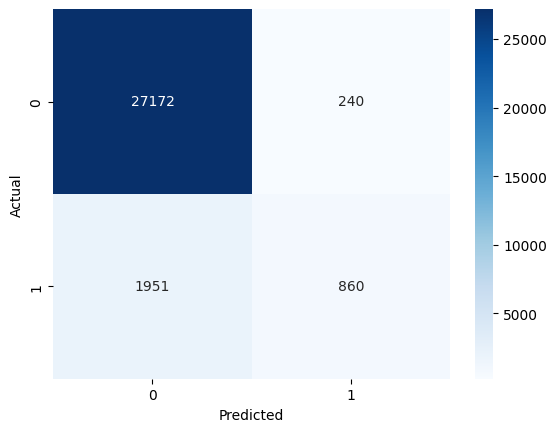

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# print(type(logisticreg))
import joblib
joblib.dump(model,'mlps.joblib')
joblib.dump(preprocesser, 'preprocessor.joblib')
# joblib.dump(decisiontree,'decisiontree.pkl')



['preprocessor.joblib']

In [ ]:
y_test[y_test==1]

15       1
24       1
27       1
37       1
45       1
        ..
30200    1
30207    1
30210    1
30217    1
30219    1
Name: class, Length: 2808, dtype: int64

In [ ]:
preds0 = x_test.iloc[[14]]


In [ ]:
preds0

,Unnamed: 0,user_id,purchase_value,source,browser,sex,age,ip_address,country,day_of_week,time_diff(hr)
14,71087,344470,28,SEO,Chrome,M,45,3868441302,undefined,0,0.0


In [ ]:
preds0 = x_test.iloc[[14]]
processed = preprocesser.transform(preds0)

In [ ]:
# processed = preprocesser.transform(preds0)
pred =model.predict(processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:
pred

array([[0.12704356]], dtype=float32)